### Importing Packages

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score

### User Defined Functions

##### Matrix Grid Heatmap

In [2]:
def heatmap(data,row_labels,col_labels,ax=None,cbar_kw={},cbarlabel='',**kwargs):
    if not ax: ax = plt.gca()
    im = ax.imshow(data,**kwargs)
    cbar = ax.figure.colorbar(im,ax=ax,**cbar_kw)
    cbar.ax.set_ylabel(cbarlabel,rotation=-90,va='bottom')
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.tick_params(top=True,bottom=False,labeltop=True,labelbottom=False)
    plt.setp(ax.get_xticklabels(),rotation=0,ha='right',rotation_mode='anchor')
    for edge,spine in ax.spines.items(): spine.set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5,minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5,minor=True)
    ax.grid(which='minor',color='w',linestyle='-',linewidth=3)
    ax.tick_params(which='minor',bottom=False,left=False)
    return im,cbar

def annotate_heatmap(im,data=None,valfmt='{x:.2f}',textcolors=['black','white'],threshold=None,**textkw):
    if not isinstance(data,(list,np.ndarray)): data = im.get_array()
    if threshold is not None: threshold = im.norm(threshold)
    else: threshold = im.norm(data.max())/2
    kw = dict(horizontalalignment='center',verticalalignment='center')
    kw.update(textkw)
    if isinstance(valfmt,str): valfmt = ticker.StrMethodFormatter(valfmt)
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i,j])>threshold)])
            text = im.axes.text(j,i,valfmt(data[i,j],None),**kw)
            texts.append(text)
    return texts

##### Linear Kernel

In [3]:
def svm_linear_data(train,test,c):
    X_train,X_test = train.iloc[:,:-1],test.iloc[:,:-1]
    y_train,y_test = train.iloc[:,-1],test.iloc[:,-1]
    train_error,test_error = [],[]
    train_f1_score,test_f1_score = [],[]
    run_time,C = [],[]
    for i in c:
        time_start = time.clock()
        model = SVC(kernel='linear',C=i)
        model.fit(X_train,y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test  = model.predict(X_test)
        error_train = 1-accuracy_score(y_train,y_pred_train)
        error_test  = 1-accuracy_score(y_test,y_pred_test)
        f1_score_train = f1_score(y_train,y_pred_train)
        f1_score_test  = f1_score(y_test,y_pred_test)
        time_elapsed = round(time.clock()-time_start,2)
        train_error.append(error_train)
        test_error.append(error_test)
        train_f1_score.append(f1_score_train)
        test_f1_score.append(f1_score_test)
        run_time.append(time_elapsed)
        C.append(i)
    dt = list(zip(C,train_error,test_error,train_f1_score,test_f1_score,run_time))
    df = pd.DataFrame(dt,columns=['c','train_error','test_error','train_f1_score','test_f1_score','run_time'])
    return df

def svm_linear_plot(df):
    plt.figure(figsize=(10,10))

    plt.subplot(2,2,1)
    plt.plot('c','train_error',data=df,color='b')
    plt.plot('c','test_error',data=df,color='r')
    plt.xlabel('C')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs C')
    plt.legend(loc='upper right')

    plt.subplot(2,2,2)
    plt.plot('run_time','train_error',data=df,color='b')
    plt.plot('run_time','test_error',data=df,color='r')
    plt.xlabel('Run Time')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Run Time')
    plt.legend(loc='upper right')

    plt.subplot(2,2,3)
    plt.plot('c','train_f1_score',data=df,color='b')
    plt.plot('c','test_f1_score',data=df,color='r')
    plt.xlabel('C')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs C')
    plt.legend(loc='upper right')

    plt.subplot(2,2,4)
    plt.plot('c','run_time',data=df)
    plt.xlabel('C')
    plt.ylabel('Run Time')
    plt.title('Run Time vs C')

    plt.show()

##### Other Kernels

In [4]:
def svm_data(train,test,c,gamma,k):
    X_train,X_test = train.iloc[:,:-1],test.iloc[:,:-1]
    y_train,y_test = train.iloc[:,-1],test.iloc[:,-1]
    train_error,test_error = [],[]
    train_f1_score,test_f1_score = [],[]
    run_time,C,Gamma = [],[],[]
    for i in c:
        for j in gamma:
            time_start = time.clock()
            model = SVC(kernel=k,C=i,gamma=j)
            model.fit(X_train,y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test  = model.predict(X_test)
            error_train = 1-accuracy_score(y_train,y_pred_train)
            error_test  = 1-accuracy_score(y_test,y_pred_test)
            f1_score_train = f1_score(y_train,y_pred_train)
            f1_score_test  = f1_score(y_test,y_pred_test)
            time_elapsed = round(time.clock()-time_start,2)
            train_error.append(error_train)
            test_error.append(error_test)
            train_f1_score.append(f1_score_train)
            test_f1_score.append(f1_score_test)
            run_time.append(time_elapsed)
            C.append(i)
            Gamma.append(j)
    dt = list(zip(C,Gamma,train_error,test_error,train_f1_score,test_f1_score,run_time))
    df = pd.DataFrame(dt,columns=['c','gamma','train_error','test_error','train_f1_score','test_f1_score','run_time'])
    return df

def svm_heatmap(df,c,gamma,metric='test_error'):
    split = np.array_split(df[metric],len(c))
    data0 = pd.DataFrame(split[0])
    for i in range(1,len(c)):
        data1 = pd.DataFrame(split[i])
        data1.index = range(len(data1.index))
        data0 = pd.concat([data0,data1],axis=1)
    array = np.array(data0)
    fig,ax = plt.subplots()
    im,cbar = heatmap(array,gamma,c,ax=ax,cmap='YlGn',cbarlabel=metric)
    texts = annotate_heatmap(im,valfmt='{x:.4f}')
    fig.tight_layout()
    plt.xlabel('C')
    plt.ylabel('Gamma')
    plt.show()
    
def svm_plot(df):
    plt.figure(figsize=(15,10))

    plt.subplot(2,3,1)
    plt.scatter('c','train_error',data=df,color='b')
    plt.scatter('c','test_error',data=df,color='r')
    plt.xlabel('C')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs C')
    plt.legend(loc='upper right')

    plt.subplot(2,3,2)
    plt.scatter('gamma','train_error',data=df,color='b')
    plt.scatter('gamma','test_error',data=df,color='r')
    plt.xlabel('Gamma')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Gamma')
    plt.legend(loc='upper right')

    plt.subplot(2,3,3)
    plt.scatter('run_time','train_error',data=df,color='b')
    plt.scatter('run_time','test_error',data=df,color='r')
    plt.xlabel('Run Time')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Run Time')
    plt.legend(loc='upper right')

    plt.subplot(2,3,4)
    plt.scatter('c','train_f1_score',data=df,color='b')
    plt.scatter('c','test_f1_score',data=df,color='r')
    plt.xlabel('C')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs C')
    plt.legend(loc='upper right')

    plt.subplot(2,3,5)
    plt.scatter('gamma','train_f1_score',data=df,color='b')
    plt.scatter('gamma','test_f1_score',data=df,color='r')
    plt.xlabel('Gamma')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Gamma')
    plt.legend(loc='upper right')

    plt.subplot(2,3,6)
    plt.scatter('run_time','c',data=df,color='cyan')
    plt.scatter('run_time','gamma',data=df,color='green')
    plt.xlabel('Run Time')
    plt.ylabel('Parameters')
    plt.title('Parameters vs Run Time')
    plt.legend(loc='upper right')

    plt.show()

##### Decision Trees

In [5]:
def tree_data(train,test,depth,nodes):
    X_train,X_test = train.iloc[:,:-1],test.iloc[:,:-1]
    y_train,y_test = train.iloc[:,-1],test.iloc[:,-1]
    train_error,test_error = [],[]
    train_f1_score,test_f1_score = [],[]
    run_time,Depth,Nodes = [],[],[]
    for i in depth:
        for j in nodes:
            time_start = time.clock()
            model = DecisionTreeClassifier(criterion='gini',max_depth=i,max_leaf_nodes=j)
            model.fit(X_train,y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test  = model.predict(X_test)
            error_train = 1-accuracy_score(y_train,y_pred_train)
            error_test  = 1-accuracy_score(y_test,y_pred_test)
            f1_score_train = f1_score(y_train,y_pred_train)
            f1_score_test  = f1_score(y_test,y_pred_test)
            time_elapsed = round(time.clock()-time_start,2)
            train_error.append(error_train)
            test_error.append(error_test)
            train_f1_score.append(f1_score_train)
            test_f1_score.append(f1_score_test)
            run_time.append(time_elapsed)
            Depth.append(i)
            Nodes.append(j)
    dt = list(zip(Depth,Nodes,train_error,test_error,train_f1_score,test_f1_score,run_time))
    df = pd.DataFrame(dt,columns=['depth','nodes','train_error','test_error','train_f1_score','test_f1_score','run_time'])
    return df

def tree_heatmap(df,depth,nodes,metric='test_error'):
    split = np.array_split(df[metric],len(depth))
    data0 = pd.DataFrame(split[0])
    for i in range(1,len(depth)):
        data1 = pd.DataFrame(split[i])
        data1.index = range(len(data1.index))
        data0 = pd.concat([data0,data1],axis=1)
    array = np.array(data0)
    fig,ax = plt.subplots()
    im,cbar = heatmap(array,nodes,depth,ax=ax,cmap='YlGn',cbarlabel=metric)
    texts = annotate_heatmap(im,valfmt='{x:.4f}')
    fig.tight_layout()
    plt.xlabel('Depth')
    plt.ylabel('Nodes')
    plt.show()

def tree_plot(df):
    plt.figure(figsize=(15,10))

    plt.subplot(2,3,1)
    plt.scatter('depth','train_error',data=df,color='b')
    plt.scatter('depth','test_error',data=df,color='r')
    plt.xlabel('Depth')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Depth')
    plt.legend(loc='upper right')

    plt.subplot(2,3,2)
    plt.scatter('nodes','train_error',data=df,color='b')
    plt.scatter('nodes','test_error',data=df,color='r')
    plt.xlabel('Nodes')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Nodes')
    plt.legend(loc='upper right')

    plt.subplot(2,3,3)
    plt.scatter('run_time','train_error',data=df,color='b')
    plt.scatter('run_time','test_error',data=df,color='r')
    plt.xlabel('Run Time')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Run Time')
    plt.legend(loc='upper right')

    plt.subplot(2,3,4)
    plt.scatter('depth','train_f1_score',data=df,color='b')
    plt.scatter('depth','test_f1_score',data=df,color='r')
    plt.xlabel('Depth')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Depth')
    plt.legend(loc='upper right')

    plt.subplot(2,3,5)
    plt.scatter('nodes','train_f1_score',data=df,color='b')
    plt.scatter('nodes','test_f1_score',data=df,color='r')
    plt.xlabel('Nodes')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Nodes')
    plt.legend(loc='upper right')

    plt.subplot(2,3,6)
    plt.scatter('run_time','depth',data=df,color='cyan')
    plt.scatter('run_time','nodes',data=df,color='green')
    plt.xlabel('Run Time')
    plt.ylabel('Parameters')
    plt.title('Parameters vs Run Time')
    plt.legend(loc='upper right')

    plt.show()

##### Adaptive Boosting

In [6]:
def adaboost_data(train,test,estimators,learning_rate):
    X_train,X_test = train.iloc[:,:-1],test.iloc[:,:-1]
    y_train,y_test = train.iloc[:,-1],test.iloc[:,-1]
    train_error,test_error = [],[]
    train_f1_score,test_f1_score = [],[]
    run_time,Estimators,LearningRate = [],[],[]
    for i in estimators:
        for j in learning_rate:
            time_start = time.clock()
            model = AdaBoostClassifier(DecisionTreeClassifier(criterion='gini',max_depth=10),n_estimators=i,learning_rate=j)
            model.fit(X_train,y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test  = model.predict(X_test)
            error_train = 1-accuracy_score(y_train,y_pred_train)
            error_test  = 1-accuracy_score(y_test,y_pred_test)
            f1_score_train = f1_score(y_train,y_pred_train)
            f1_score_test  = f1_score(y_test,y_pred_test)
            time_elapsed = round(time.clock()-time_start,2)
            train_error.append(error_train)
            test_error.append(error_test)
            train_f1_score.append(f1_score_train)
            test_f1_score.append(f1_score_test)
            run_time.append(time_elapsed)
            Estimators.append(i)
            LearningRate.append(j)
    dt = list(zip(Estimators,LearningRate,train_error,test_error,train_f1_score,test_f1_score,run_time))
    df = pd.DataFrame(dt,columns=['estimators','learning_rate','train_error','test_error','train_f1_score','test_f1_score','run_time'])
    return df

def adaboost_heatmap(df,estimators,learning_rate,metric='test_error'):
    split = np.array_split(df[metric],len(estimators))
    data0 = pd.DataFrame(split[0])
    for i in range(1,len(estimators)):
        data1 = pd.DataFrame(split[i])
        data1.index = range(len(data1.index))
        data0 = pd.concat([data0,data1],axis=1)
    array = np.array(data0)
    fig,ax = plt.subplots()
    im,cbar = heatmap(array,learning_rate,estimators,ax=ax,cmap='YlGn',cbarlabel=metric)
    texts = annotate_heatmap(im,valfmt='{x:.4f}')
    fig.tight_layout()
    plt.xlabel('Estimators')
    plt.ylabel('Learning Rate')
    plt.show()

def adaboost_plot(df):
    plt.figure(figsize=(15,10))

    plt.subplot(2,3,1)
    plt.scatter('estimators','train_error',data=df,color='b')
    plt.scatter('estimators','test_error',data=df,color='r')
    plt.xlabel('Estimators')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Estimators')
    plt.legend(loc='upper right')

    plt.subplot(2,3,2)
    plt.scatter('learning_rate','train_error',data=df,color='b')
    plt.scatter('learning_rate','test_error',data=df,color='r')
    plt.xlabel('Learning Rate')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Learning Rate')
    plt.legend(loc='upper right')

    plt.subplot(2,3,3)
    plt.scatter('run_time','train_error',data=df,color='b')
    plt.scatter('run_time','test_error',data=df,color='r')
    plt.xlabel('Run Time')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Run Time')
    plt.legend(loc='upper right')

    plt.subplot(2,3,4)
    plt.scatter('estimators','train_f1_score',data=df,color='b')
    plt.scatter('estimators','test_f1_score',data=df,color='r')
    plt.xlabel('Estimators')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Estimators')
    plt.legend(loc='upper right')

    plt.subplot(2,3,5)
    plt.scatter('learning_rate','train_f1_score',data=df,color='b')
    plt.scatter('learning_rate','test_f1_score',data=df,color='r')
    plt.xlabel('Learning Rate')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Learning Rate')
    plt.legend(loc='upper right')

    plt.subplot(2,3,6)
    plt.scatter('run_time','estimators',data=df,color='cyan')
    plt.scatter('run_time','learning_rate',data=df,color='green')
    plt.xlabel('Run Time')
    plt.ylabel('Parameters')
    plt.title('Parameters vs Run Time')
    plt.legend(loc='upper right')

    plt.show()

##### Cross Validation

In [7]:
def adaboost_cv_params(X,y,estimators,learning_rate,folds=5):
    time_start = time.clock()
    param_grid = {'n_estimators':estimators,'learning_rate':learning_rate}
    cv = StratifiedKFold(n_splits=folds,shuffle=True,random_state=3421107)
    grid_search = GridSearchCV(AdaBoostClassifier(),param_grid,cv=cv)
    grid_search.fit(X,y)
    grid_search.best_params_
    time_elapsed = time.clock() - time_start
    print(time_elapsed)
    return grid_search.best_params_

### Dataset 1 - Appliances Energy Prediction

##### Data Preprocessing

Response classes in train set
 -1.0    7536
 1.0    6278
Name: Heavy_Appliances, dtype: int64

Response classes in test set
 -1.0    3208
 1.0    2713
Name: Heavy_Appliances, dtype: int64


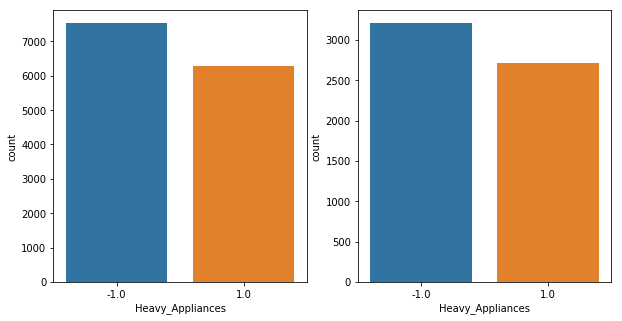

In [8]:
# ignoring warnings
warnings.filterwarnings('ignore')

# importing dataset
data1 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
data1 = data1.iloc[:,1:-2]

# splitting into train & test
train1,test1 = train_test_split(data1,test_size=0.3,random_state=3421107)

# classifying response > median
train1['Heavy_Appliances'] = np.where(train1.Appliances > train1.Appliances.median(),1,0)
test1['Heavy_Appliances']  = np.where(test1.Appliances > train1.Appliances.median(),1,0)

# splitting datasets into X,y
X_train1,X_test1 = train1.iloc[:,1:-1],test1.iloc[:,1:-1]
y_train1,y_test1 = train1.iloc[:,-1],test1.iloc[:,-1]

# normalizing data to [-1,1]
X_train1 = (X_train1-X_train1.mean())/(X_train1.max()-X_train1.min())
X_test1  = (X_test1-X_train1.mean())/(X_train1.max()-X_train1.min())
y_train1 = ((y_train1-y_train1.max())+(y_train1-y_train1.min()))/(y_train1.max()-y_train1.min())
y_test1  = ((y_test1-y_test1.max())+(y_test1-y_test1.min()))/(y_test1.max()-y_test1.min())

# combining normalized X and y
train1 = pd.concat([X_train1,y_train1],axis=1)
test1  = pd.concat([X_test1,y_test1],axis=1)

# frequency of response classes
print('Response classes in train set\n',y_train1.value_counts())
print('\nResponse classes in test set\n',y_test1.value_counts())
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.countplot(train1.Heavy_Appliances,ax=axes[0])
sns.countplot(test1.Heavy_Appliances,ax=axes[1])
plt.show()

##### SVM with Linear Kernel

In [9]:
c = [0.01,0.05,0.1,0.2,0.5,1,2,5,10,20,25]
lin1 = svm_linear_data(train1,test1,c)
lin1.sort_values(by='test_f1_score',ascending=False)

,c,train_error,test_error,train_f1_score,test_f1_score,run_time
9,20.00,0.234327,0.393008,0.737235,0.284220,13.72
8,10.00,0.235703,0.398412,0.736185,0.264422,11.94
10,25.00,0.234472,0.400439,0.737030,0.254637,16.01
7,5.00,0.235413,0.403648,0.736680,0.240788,11.24
5,1.00,0.236934,0.406519,0.736197,0.229760,9.50
6,2.00,0.235703,0.407701,0.736868,0.224791,9.99
4,0.50,0.237947,0.451444,0.735154,0.033972,10.18
0,0.01,0.281888,0.458200,0.661920,0.000000,13.52
1,0.05,0.255393,0.458200,0.711953,0.000000,10.86
2,0.10,0.249602,0.458200,0.721621,0.000000,10.08


In [48]:
lin1.sort_values(by='test_error',ascending=True)

,c,train_error,test_error,train_f1_score,test_f1_score,run_time
9,20.00,0.234327,0.393008,0.737235,0.284220,13.72
8,10.00,0.235703,0.398412,0.736185,0.264422,11.94
10,25.00,0.234472,0.400439,0.737030,0.254637,16.01
7,5.00,0.235413,0.403648,0.736680,0.240788,11.24
5,1.00,0.236934,0.406519,0.736197,0.229760,9.50
6,2.00,0.235703,0.407701,0.736868,0.224791,9.99
4,0.50,0.237947,0.451444,0.735154,0.033972,10.18
0,0.01,0.281888,0.458200,0.661920,0.000000,13.52
1,0.05,0.255393,0.458200,0.711953,0.000000,10.86
2,0.10,0.249602,0.458200,0.721621,0.000000,10.08


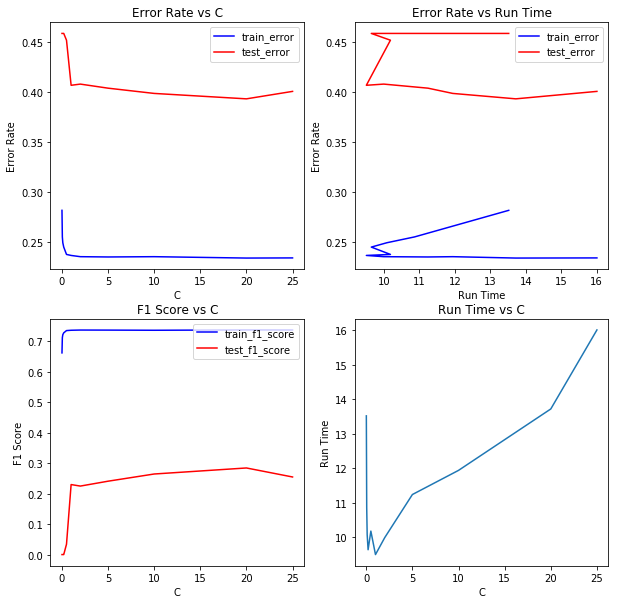

In [10]:
svm_linear_plot(lin1)

##### SVM with RBF Kernel

In [11]:
c = [0.001,0.01,0.1,1,10]
gamma = [0.001,0.01,0.1,1,10]
rbf1 = svm_data(train1,test1,c,gamma,k='rbf')
rbf1.sort_values(by='test_f1_score',ascending=False).head(10)

,c,gamma,train_error,test_error,train_f1_score,test_f1_score,run_time
12,0.1,0.100,0.268641,0.5418,0.687600,0.628446,20.37
13,0.1,1.000,0.210294,0.5418,0.764224,0.628446,17.40
23,10.0,1.000,0.121471,0.5418,0.862931,0.628446,13.09
22,10.0,0.100,0.199870,0.5418,0.773000,0.628446,15.78
21,10.0,0.010,0.240915,0.5418,0.729958,0.628446,17.50
20,10.0,0.001,0.267265,0.5418,0.692077,0.628446,17.84
19,1.0,10.000,0.086796,0.5418,0.902544,0.628446,13.93
18,1.0,1.000,0.157883,0.5418,0.821741,0.628446,15.34
17,1.0,0.100,0.234110,0.5418,0.736902,0.628446,17.85
16,1.0,0.010,0.267555,0.5418,0.691073,0.628446,22.08


In [49]:
rbf1.sort_values(by='test_error',ascending=True).head(10)

,c,gamma,train_error,test_error,train_f1_score,test_f1_score,run_time
0,0.001,0.001,0.454466,0.4582,0.000000,0.000000,22.39
1,0.001,0.010,0.454466,0.4582,0.000000,0.000000,26.07
2,0.001,0.100,0.454466,0.4582,0.000000,0.000000,26.70
3,0.001,1.000,0.454466,0.4582,0.000000,0.000000,25.57
4,0.001,10.000,0.454466,0.4582,0.000000,0.000000,23.97
5,0.010,0.001,0.454466,0.4582,0.000000,0.000000,21.85
6,0.010,0.010,0.454466,0.4582,0.000000,0.000000,24.24
9,0.010,10.000,0.454105,0.4582,0.001592,0.000000,25.10
10,0.100,0.001,0.454466,0.4582,0.000000,0.000000,21.21
22,10.000,0.100,0.199870,0.5418,0.773000,0.628446,15.78


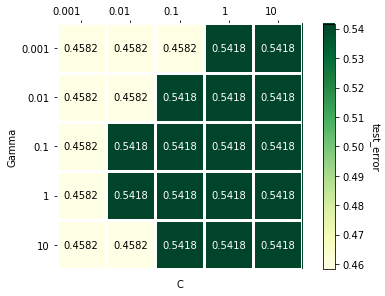

In [12]:
svm_heatmap(rbf1,c,gamma,metric='test_error')

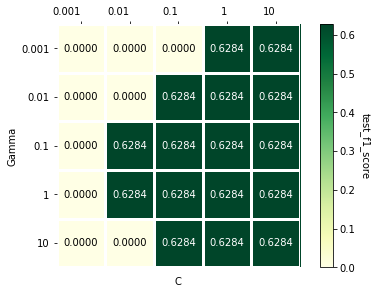

In [13]:
svm_heatmap(rbf1,c,gamma,metric='test_f1_score')

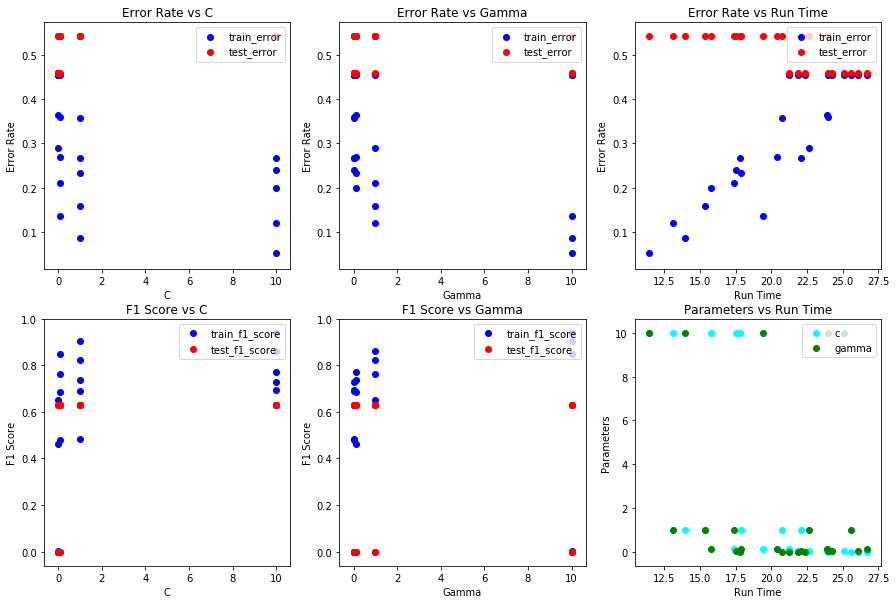

In [14]:
svm_plot(rbf1)

##### SVM with Sigmoid Kernel

In [15]:
c = [0.001,0.01,0.1,1,10]
gamma = [0.001,0.01,0.1,1,10]
sig1 = svm_data(train1,test1,c,gamma,k='sigmoid')
sig1.sort_values(by='test_f1_score',ascending=False).head(5)

,c,gamma,train_error,test_error,train_f1_score,test_f1_score,run_time
19,1.0,10.00,0.472781,0.476102,0.479892,0.634986,16.88
21,10.0,0.01,0.249602,0.496031,0.721621,0.634110,19.00
24,10.0,10.00,0.472709,0.474413,0.479930,0.634102,16.97
22,10.0,0.10,0.296076,0.541800,0.660750,0.628446,17.46
14,0.1,10.00,0.472202,0.459551,0.480363,0.623912,16.89


In [50]:
sig1.sort_values(by='test_error',ascending=True).head(5)

,c,gamma,train_error,test_error,train_f1_score,test_f1_score,run_time
9,0.010,10.000,0.470971,0.416484,0.479437,0.523386,17.98
0,0.001,0.001,0.454466,0.458200,0.000000,0.000000,24.98
20,10.000,0.001,0.281888,0.458200,0.661920,0.000000,21.90
18,1.000,1.000,0.398871,0.458200,0.561306,0.000000,11.73
16,1.000,0.010,0.281888,0.458200,0.661920,0.000000,21.39


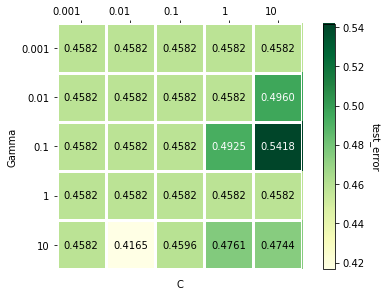

In [16]:
svm_heatmap(sig1,c,gamma,metric='test_error')

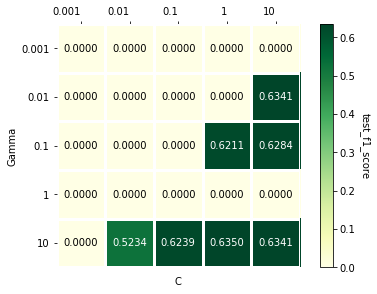

In [17]:
svm_heatmap(sig1,c,gamma,metric='test_f1_score')

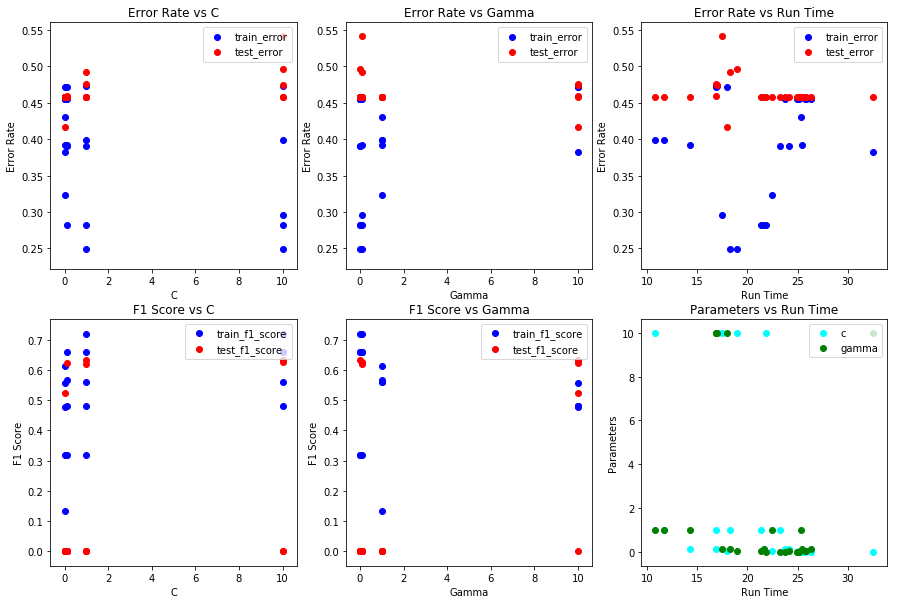

In [18]:
svm_plot(sig1)

##### Decision Trees

In [19]:
depth = [5,10,15,20,25]
nodes = [5,10,15,20,25]
tree1 = tree_data(train1,test1,depth,nodes)
tree1.sort_values(by='test_f1_score',ascending=False).head(5)

,depth,nodes,train_error,test_error,train_f1_score,test_f1_score,run_time
21,25,10,0.278775,0.5418,0.697510,0.628446,0.12
6,10,10,0.278775,0.5418,0.697510,0.628446,0.13
11,15,10,0.278775,0.5418,0.697510,0.628446,0.13
1,5,10,0.287028,0.5418,0.673151,0.628446,0.13
16,20,10,0.278775,0.5418,0.697510,0.628446,0.12


In [51]:
tree1.sort_values(by='test_error',ascending=True).head(5)

,depth,nodes,train_error,test_error,train_f1_score,test_f1_score,run_time
0,5,5,0.294484,0.355345,0.659468,0.483808,0.11
5,10,5,0.294484,0.355345,0.659468,0.483808,0.12
20,25,5,0.294484,0.355345,0.659468,0.483808,0.09
10,15,5,0.294484,0.355345,0.659468,0.483808,0.10
15,20,5,0.294484,0.355345,0.659468,0.483808,0.10


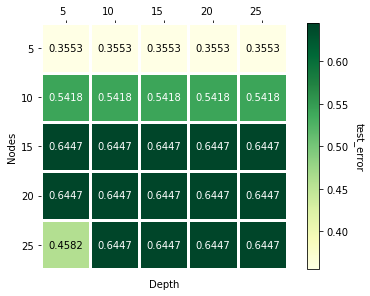

In [20]:
tree_heatmap(tree1,depth,nodes,metric='test_error')

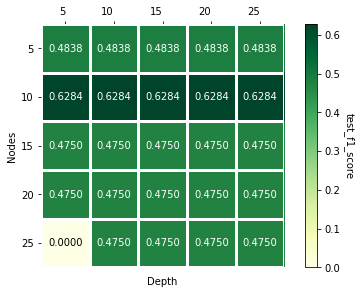

In [21]:
tree_heatmap(tree1,depth,nodes,metric='test_f1_score')

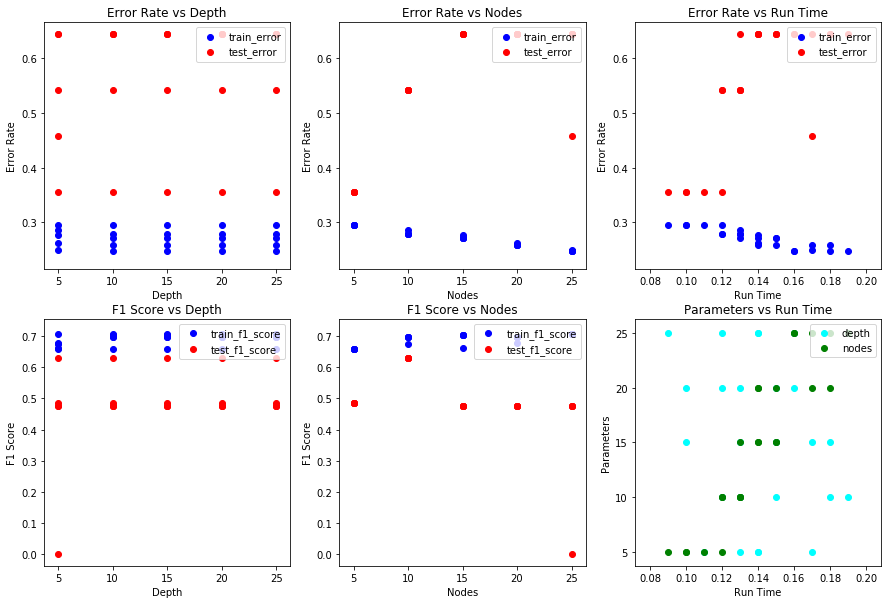

In [22]:
tree_plot(tree1)

##### Adaptive Boosting

In [23]:
estimators = [10,50,100,200,500,1000]
learning_rate = [0.005,0.01,0.05,0.1,0.2,0.5]
ada1 = adaboost_data(train1,test1,estimators,learning_rate)
ada1.sort_values(by='test_f1_score',ascending=False).head(5)

,estimators,learning_rate,train_error,test_error,train_f1_score,test_f1_score,run_time
34,1000,0.20,0.000000,0.512245,1.000000,0.638714,223.73
20,200,0.05,0.000000,0.506502,1.000000,0.637846,45.82
28,500,0.20,0.000000,0.505827,1.000000,0.637804,106.61
4,10,0.20,0.010062,0.512751,0.988845,0.634921,2.54
10,50,0.20,0.000000,0.511231,1.000000,0.633313,10.98


In [52]:
ada1.sort_values(by='test_error',ascending=True).head(5)

,estimators,learning_rate,train_error,test_error,train_f1_score,test_f1_score,run_time
2,10,0.05,0.019256,0.356359,0.978475,0.483097,2.41
17,100,0.50,0.000000,0.367674,1.000000,0.524776,21.88
23,200,0.50,0.000000,0.371390,1.000000,0.419022,43.03
26,500,0.05,0.000000,0.371559,1.000000,0.420748,111.96
3,10,0.10,0.019835,0.377470,0.977756,0.434034,2.36


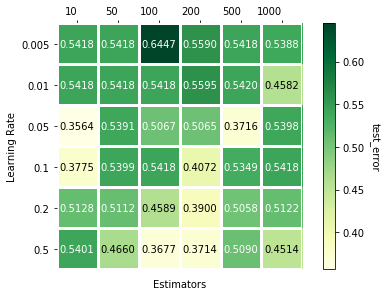

In [24]:
adaboost_heatmap(ada1,estimators,learning_rate,metric='test_error')

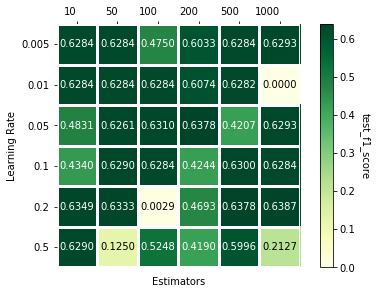

In [25]:
adaboost_heatmap(ada1,estimators,learning_rate,metric='test_f1_score')

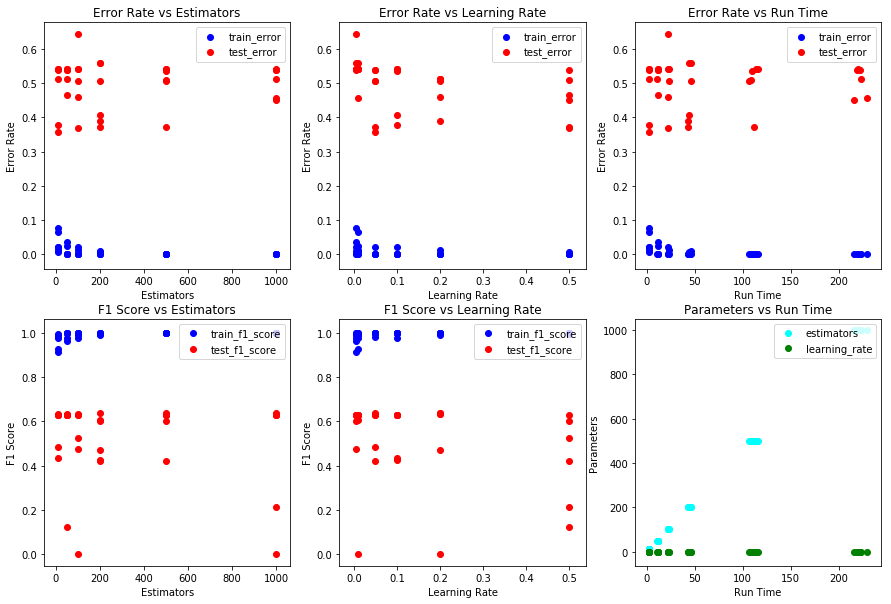

In [26]:
adaboost_plot(ada1)

In [27]:
estimators = [10,50,100,200,500,1000]
learning_rate = [0.005,0.01,0.05,0.1,0.2,0.5]
ada1_cv = adaboost_cv_params(X_train1,y_train1,estimators,learning_rate,folds=5)
ada1_cv

1268.0211349000006


{'learning_rate': 0.5, 'n_estimators': 1000}

### Dataset 2 - Online Shoppers Purchasing Intention

##### Data Preprocessing

Response classes in train set
 -1.0    7276
 1.0    1355
Name: Revenue, dtype: int64

Response classes in test set
 -1.0    3146
 1.0     553
Name: Revenue, dtype: int64


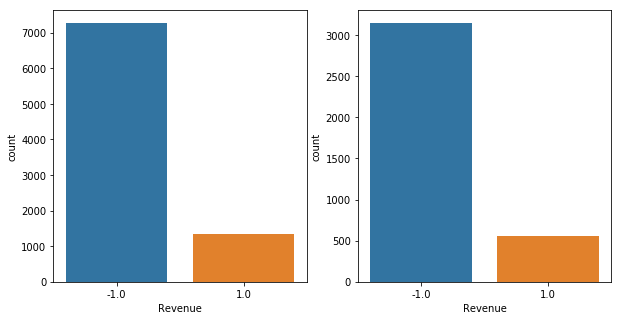

In [28]:
# ignoring warnings
warnings.filterwarnings('ignore')

# importing dataset
data2 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')

# creating dummies
for i in range (10,16):
    dummy = pd.get_dummies(data2[data2.columns[i]],prefix=data2.columns[i])
    data2 = pd.concat([data2,dummy],axis=1)
cols2 = data2.columns
data2 = pd.concat([data2[list(cols2[:10])+list(cols2[18:])],data2.Weekend.astype(int),data2.Revenue.astype(int)],axis=1)

# splitting into train & test
train2,test2 = train_test_split(data2,test_size=0.3,random_state=3421107)

# splitting datasets into X,y
X_train2,X_test2 = train2.iloc[:,:-1],test2.iloc[:,:-1]
y_train2,y_test2 = train2.iloc[:,-1],test2.iloc[:,-1]

# normalizing data to [-1,1]
X_train2 = (X_train2-X_train2.mean())/(X_train2.max()-X_train2.min())
X_test2  = (X_test2-X_train2.mean())/(X_train2.max()-X_train2.min())
y_train2 = ((y_train2-y_train2.max())+(y_train2-y_train2.min()))/(y_train2.max()-y_train2.min())
y_test2  = ((y_test2-y_test2.max())+(y_test2-y_test2.min()))/(y_test2.max()-y_test2.min())

# combining normalized X and y
train2 = pd.concat([X_train2,y_train2],axis=1)
test2  = pd.concat([X_test2,y_test2],axis=1)

# frequency of response classes
print('Response classes in train set\n',y_train2.value_counts())
print('\nResponse classes in test set\n',y_test2.value_counts())
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.countplot(train2.Revenue,ax=axes[0])
sns.countplot(test2.Revenue,ax=axes[1])
plt.show()

##### SVM with Linear Kernel

In [29]:
c = [0.0001,0.0005,0.001,0.005,0.01,0.05]
lin2 = svm_linear_data(train2,test2,c)
lin2.sort_values(by='test_f1_score',ascending=False)

,c,train_error,test_error,train_f1_score,test_f1_score,run_time
2,0.0010,0.156992,0.196269,0.000000,0.542245,4.68
1,0.0005,0.156992,0.133009,0.000000,0.517647,4.74
3,0.0050,0.156992,0.519059,0.000000,0.350474,5.10
4,0.0100,0.156992,0.568802,0.000000,0.334177,5.41
5,0.0500,0.154559,0.737226,0.038905,0.284064,5.35
0,0.0001,0.156992,0.149500,0.000000,0.067454,4.41


In [54]:
lin2.sort_values(by='test_error',ascending=True)

,c,train_error,test_error,train_f1_score,test_f1_score,run_time
1,0.0005,0.156992,0.133009,0.000000,0.517647,4.74
0,0.0001,0.156992,0.149500,0.000000,0.067454,4.41
2,0.0010,0.156992,0.196269,0.000000,0.542245,4.68
3,0.0050,0.156992,0.519059,0.000000,0.350474,5.10
4,0.0100,0.156992,0.568802,0.000000,0.334177,5.41
5,0.0500,0.154559,0.737226,0.038905,0.284064,5.35


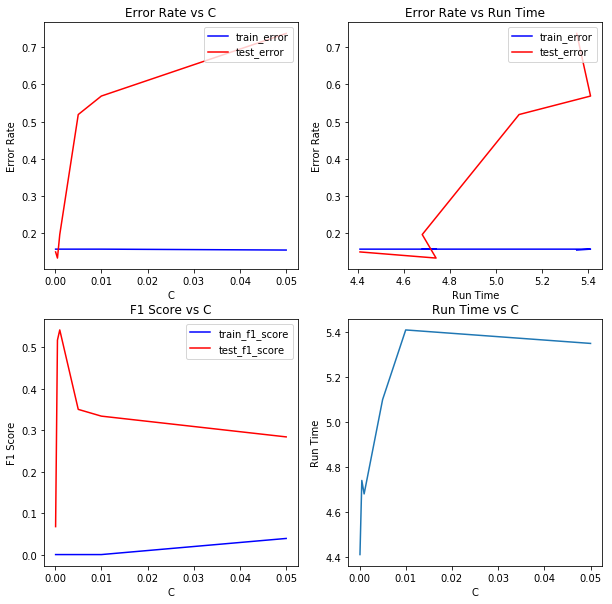

In [30]:
svm_linear_plot(lin2)

##### SVM with RBF Kernel

In [31]:
c = [0.001,0.01,0.1,1,10]
gamma = [0.001,0.01,0.1,1,10]
rbf2 = svm_data(train2,test2,c,gamma,k='rbf')
rbf2.sort_values(by='test_f1_score',ascending=False).head(1)

,c,gamma,train_error,test_error,train_f1_score,test_f1_score,run_time
20,10.0,0.001,0.156645,0.148959,0.004418,0.007207,7.74


In [53]:
rbf2.sort_values(by='test_error',ascending=True).head(1)

,c,gamma,train_error,test_error,train_f1_score,test_f1_score,run_time
20,10.0,0.001,0.156645,0.148959,0.004418,0.007207,7.74


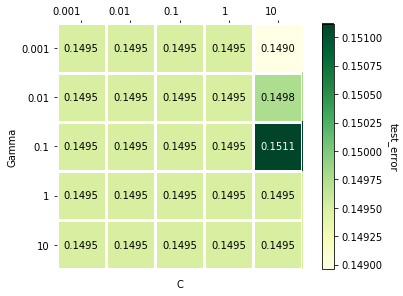

In [32]:
svm_heatmap(rbf2,c,gamma,metric='test_error')

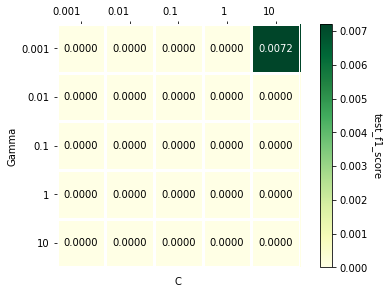

In [33]:
svm_heatmap(rbf2,c,gamma,metric='test_f1_score')

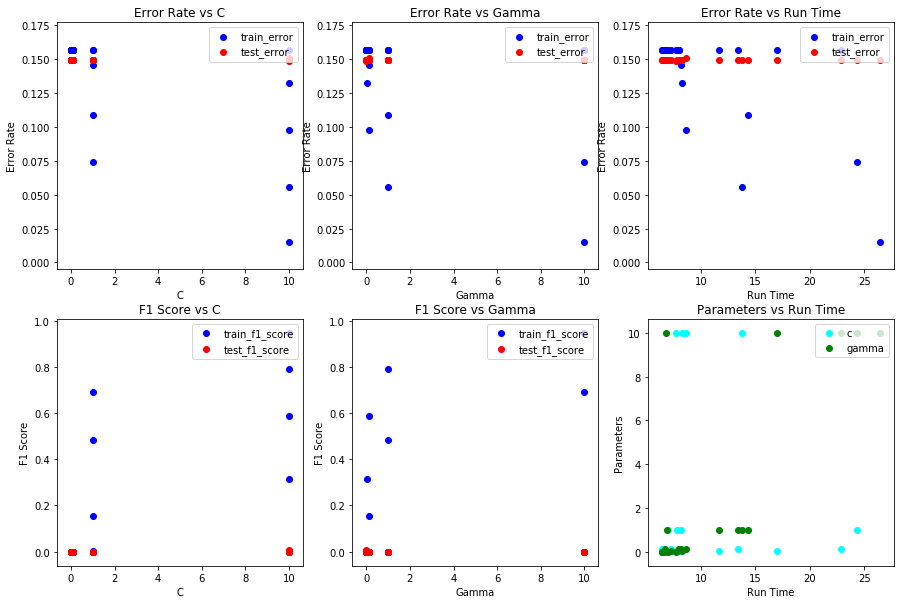

In [34]:
svm_plot(rbf2)

##### SVM with Sigmoid Kernel

In [35]:
c = [0.001,0.01,0.1,1,10]
gamma = [0.001,0.01,0.1,1,10]
sig2 = svm_data(train2,test2,c,gamma,k='sigmoid')
sig2.sort_values(by='test_f1_score',ascending=False).head(5)

,c,gamma,train_error,test_error,train_f1_score,test_f1_score,run_time
7,0.01,0.100,0.156992,0.107867,0.0,0.523297,8.52
15,1.00,0.001,0.156992,0.290078,0.0,0.467494,7.09
11,0.10,0.010,0.156992,0.350635,0.0,0.402579,7.17
20,10.00,0.001,0.156992,0.618275,0.0,0.315064,8.27
16,1.00,0.010,0.156992,0.500676,0.0,0.294745,8.13


In [55]:
sig2.sort_values(by='test_error',ascending=True).head(5)

,c,gamma,train_error,test_error,train_f1_score,test_f1_score,run_time
7,0.010,0.100,0.156992,0.107867,0.0,0.523297,8.52
3,0.001,1.000,0.156992,0.141930,0.0,0.102564,8.42
4,0.001,10.000,0.156992,0.143012,0.0,0.092624,8.21
6,0.010,0.010,0.156992,0.146796,0.0,0.038938,6.93
0,0.001,0.001,0.156992,0.149500,0.0,0.000000,6.59


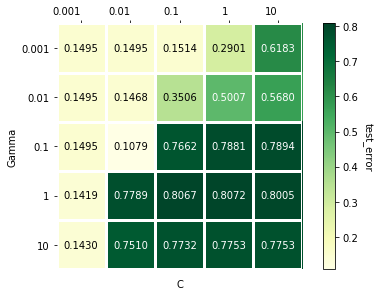

In [36]:
svm_heatmap(sig2,c,gamma,metric='test_error')

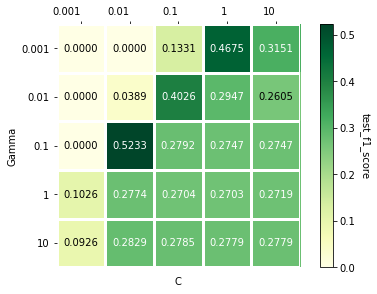

In [37]:
svm_heatmap(sig2,c,gamma,metric='test_f1_score')

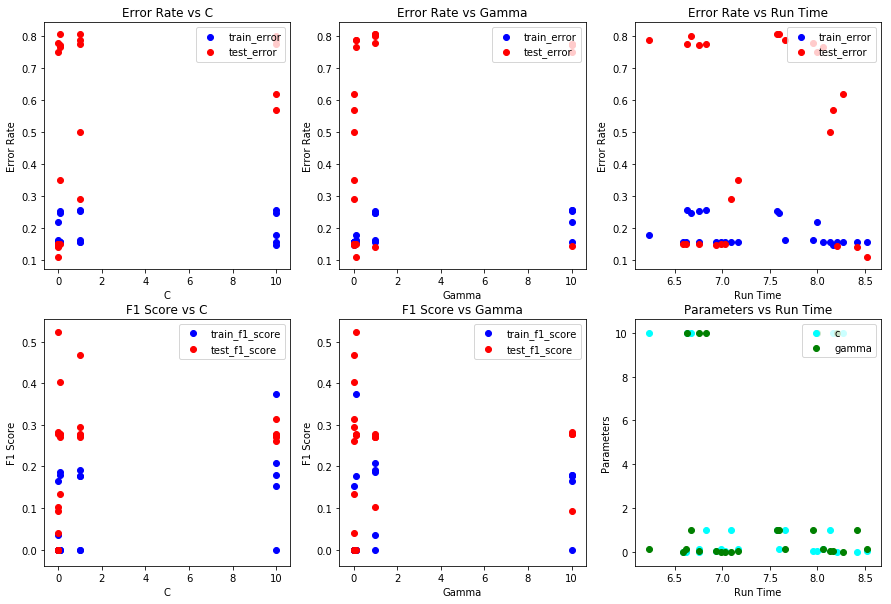

In [38]:
svm_plot(sig2)

##### Decision Trees

In [39]:
depth = [10,20,50,100,200]
nodes = [50,75,100,150,200]
tree2 = tree_data(train2,test2,depth,nodes)
tree2.sort_values(by='test_f1_score',ascending=False).head(5)

,depth,nodes,train_error,test_error,train_f1_score,test_f1_score,run_time
4,10,200,0.047851,0.281427,0.834998,0.357011,0.08
7,20,100,0.065809,0.262503,0.765870,0.353098,0.09
2,10,100,0.065230,0.264125,0.766487,0.352551,0.07
22,200,100,0.065809,0.264125,0.765289,0.352551,0.06
17,100,100,0.065809,0.264125,0.765870,0.352551,0.06


In [56]:
tree2.sort_values(by='test_error',ascending=True).head(5)

,depth,nodes,train_error,test_error,train_f1_score,test_f1_score,run_time
0,10,50,0.078438,0.2598,0.710064,0.323716,0.08
5,20,50,0.078438,0.2598,0.710064,0.323716,0.06
20,200,50,0.078438,0.2598,0.710064,0.323716,0.05
10,50,50,0.078786,0.2598,0.707149,0.323716,0.06
15,100,50,0.078438,0.2598,0.710064,0.323716,0.06


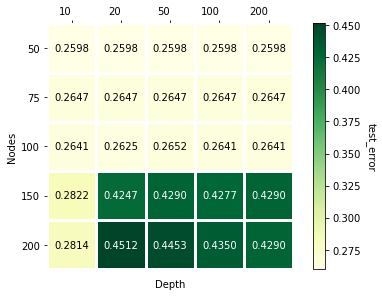

In [40]:
tree_heatmap(tree2,depth,nodes,metric='test_error')

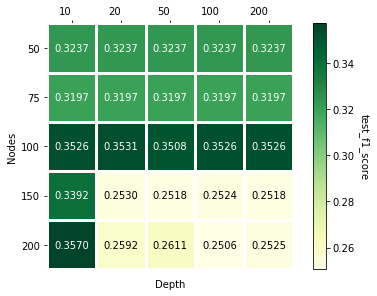

In [41]:
tree_heatmap(tree2,depth,nodes,metric='test_f1_score')

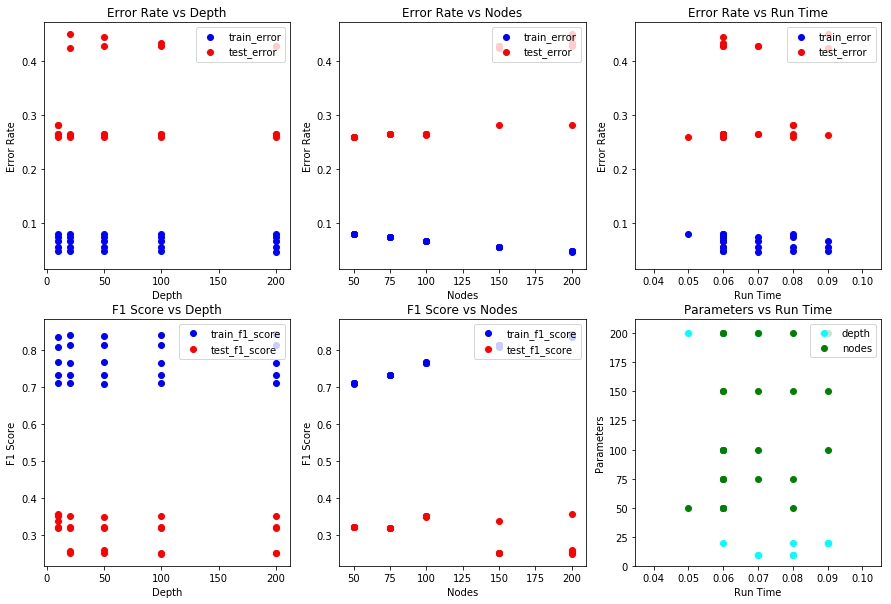

In [42]:
tree_plot(tree2)

##### Adaptive Boosting

In [43]:
estimators = [5,10,20,50,100,200]
learning_rate = [0.02,0.05,0.1,0.2,0.5,1]
ada2 = adaboost_data(train2,test2,estimators,learning_rate)
ada2.sort_values(by='test_f1_score',ascending=False).head(10)

,estimators,learning_rate,train_error,test_error,train_f1_score,test_f1_score,run_time
15,20,0.20,0.000000,0.131657,1.000000,0.542723,1.46
0,5,0.02,0.012513,0.201135,0.958873,0.394137,0.34
25,100,0.05,0.000000,0.170316,1.000000,0.377470,7.16
13,20,0.05,0.000000,0.277643,1.000000,0.375684,1.44
7,10,0.05,0.002433,0.177886,0.992190,0.356164,0.71
32,200,0.10,0.000000,0.134090,1.000000,0.355844,14.73
5,5,1.00,0.001970,0.474993,0.993720,0.342686,0.38
3,5,0.20,0.009964,0.279535,0.967300,0.338028,0.37
16,20,0.50,0.000000,0.413625,1.000000,0.307692,1.69
30,200,0.02,0.000000,0.213031,1.000000,0.306338,14.64


In [57]:
ada2.sort_values(by='test_error',ascending=True).head(10)

,estimators,learning_rate,train_error,test_error,train_f1_score,test_f1_score,run_time
15,20,0.20,0.000000,0.131657,1.00000,0.542723,1.46
32,200,0.10,0.000000,0.134090,1.00000,0.355844,14.73
10,10,0.50,0.000000,0.143282,1.00000,0.208955,0.69
28,100,0.50,0.000000,0.154636,1.00000,0.114551,7.40
18,50,0.02,0.000000,0.155447,1.00000,0.226110,3.63
20,50,0.10,0.000000,0.158151,1.00000,0.231275,3.73
34,200,0.50,0.000000,0.159232,1.00000,0.054575,14.36
12,20,0.02,0.000811,0.160314,0.99741,0.003361,1.33
29,100,1.00,0.000000,0.160584,1.00000,0.195122,6.84
23,50,1.00,0.000000,0.164909,1.00000,0.162088,3.49


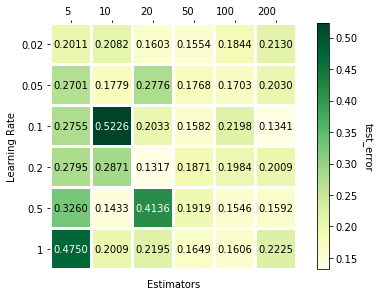

In [44]:
adaboost_heatmap(ada2,estimators,learning_rate,metric='test_error')

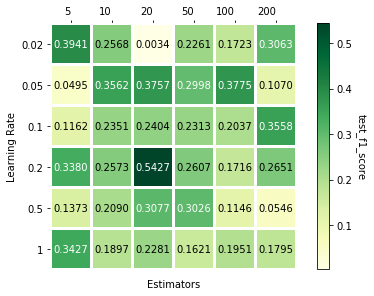

In [45]:
adaboost_heatmap(ada2,estimators,learning_rate,metric='test_f1_score')

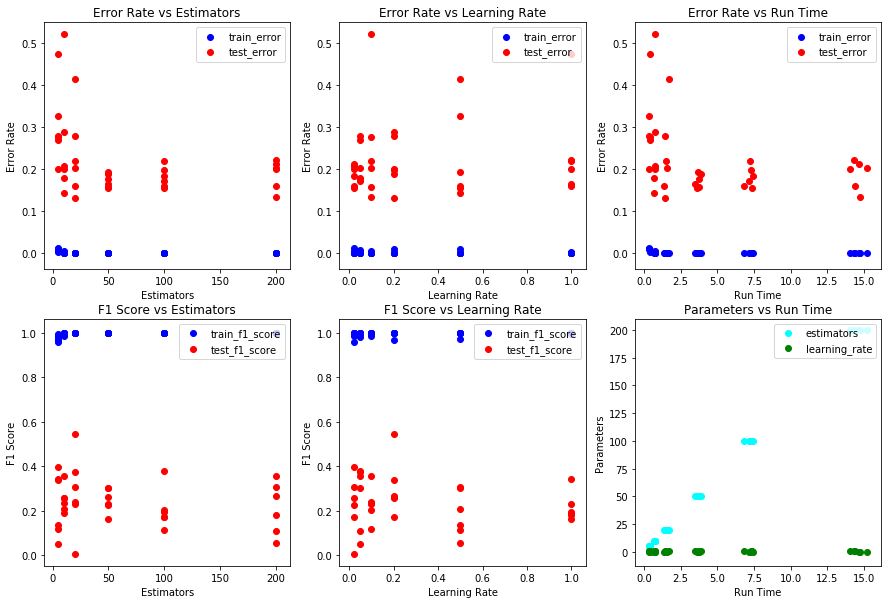

In [46]:
adaboost_plot(ada2)

In [47]:
estimators = [5,10,20,50,100,200]
learning_rate = [0.02,0.05,0.1,0.2,0.5,1]
ada2_cv = adaboost_cv_params(X_train2,y_train2,estimators,learning_rate,folds=5)
ada2_cv

119.50932569999986


{'learning_rate': 0.1, 'n_estimators': 50}